In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Ouverture du csv, un peu long car volumineux**

In [3]:
df=pd.read_csv('/content/gdrive/My Drive/Val_projet/airbnb.csv',";")

Le dataframe est immense et nous n'allons pas tout utiliser, nous supprimons toutes les colonnes qui ne sont pas utiles à notre recherche. Nous pourrons toujours venir les rechercher si nous en avons le besoin


In [4]:
#Premiere supression de variables pas utiles à notre analyse
df=df.drop(['Listing Url','Scrape ID','Last Scraped','Host Acceptance Rate','Scrape ID','Last Scraped',
            'Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Acceptance Rate',
           'Host Thumbnail Url','Host Picture Url','Host Verifications','Neighbourhood','Neighbourhood Group Cleansed',
           'Geolocation','Has Availability','Calendar last Scraped','License','Jurisdiction Names'], axis=1)

In [5]:
#deuxieme supression de variables pas utiles à notre analyse
df=df.drop(['Summary','Space','Experiences Offered','Notes','Access','State','Zipcode','Host Name','Host Location','Host Neighbourhood', 'Host ID',
           'Host Listings Count','Smart Location','Country Code','Square Feet','Security Deposit','Calendar Updated',
            'Guests Included','Extra People','Street','Country','Cancellation Policy','Calculated host listings count','Features','Market'], axis=1)

In [6]:
#On rename les colonnes qui ont des espaces
df.rename(columns={'ID':"id",'Name': 'name', 'Description': 'description', 'Host About': 'host_about', 'Host Response Time': 'host_response_time', 'Host Response Rate': 'host_response_rate', 'Host Total Listings Count': 'host_total_listing_count', 'Neighbourhood Cleansed': 'neighbourhood_cleansed' , 'City': 'city', 'Property Type': 'property_type', 'Room Type': 'room_type', 'Accommodates': 'accommodates'
, 'Bathrooms': 'bathrooms', 'Bedrooms': 'bedrooms', 'Beds': 'beds', 'Bed Type': 'bed_type', 'Amenities': 'amenities', 'Price': 'price', 'Weekly Price': 'weekly_price', 'Monthly Price': 'monthly_price', 'Cleaning Fee': 'cleaning_fee', 'Minimum Nights': 'minimum_nights', 'Maximum Nights': 'maximum_nights', 'Availability 30': 'availability_30', 'Availability 60': 'availability_60', 'Availability 90': 'availability_90', 'Availability 365': 'availability_365', 'Number of Reviews': 'number_of_reviews', 'First Review': 'first_review'
, 'Last Review': 'last_review', 'Review Scores Rating': 'review_scores_rating', 'Review Scores Accuracy': 'review_scores_accuracy', 'Review Scores Cleanliness': 'review_scores_cleanliness', 'Review Scores Checkin': 'review_scores_checkin', 'Review Scores Communication': 'review_scores_communication', 'Review Scores Location': 'review_scores_location', 'Review Scores Value': 'review_scores_value', 'Reviews per Month': 'reviews_per_month', 'Longitude': 'longitude','Latitude': 'latitude',"Neighborhood Overview":"neighborhood_overview","Transit":"transit","Interaction":"interaction","House Rules":"house_rules","Host Since":"host_since"}, inplace=True)

In [7]:
# on met la colonne id en index

df=df.set_index("id")

In [8]:
#Nous allons nous concentrer sur les villes de Paris et Londres, en les différenciant,
# afin de bien voir quels sont les mots les plus utilisés pour chaque ville, qui sont vraisemblablement dépendants du contexte 

df_paris=df[df.city=='Paris']
df_london=df[df.city=='London']


In [9]:
#Nous allons garder uniquement les types de propriété 'Apartment' et 'House' qui représente 99,6% du dataset
df_paris['property_type']=df_paris['property_type'].loc[df_paris['property_type'].isin(['Apartment','House'])]
df_london['property_type']=df_london['property_type'].loc[df_london['property_type'].isin(['Apartment','House'])]


In [10]:
#Nous allons garder uniquement les types de chambre 'Entire home/apt' et 'Private room' qui représente 99,9% du dataset
df_paris['room_type']=df_paris['room_type'].loc[df_paris['room_type'].isin(['Entire home/apt','Private room'])]
df_london['room_type']=df_london['room_type'].loc[df_london['room_type'].isin(['Entire home/apt','Private room'])]


In [11]:

#On supprimme la première ligne de df_london car elle pose problème pour la visualisation par la suite et elle contient beaucoup de valeurs "Non-renseignées"
df_london.drop( df_london.index[0], inplace=True)


In [12]:
#On supprime les lignes dont les reviews ne sont pas renseignés étant donnée que c'est un point important de notre analyse
df_paris=df_paris.dropna(axis=0,subset=["first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])
df_london=df_london.dropna(axis=0,subset=["first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])

In [13]:
#Maintenant que toutes les données ont une note attribuée, nous allons affiner en retirant les lignes qui ont des nans et qui peuvent fausser notre analyse.
df_paris=df_paris.dropna(axis=0,subset=["description","name","host_since","host_total_listing_count","price"])
df_london=df_london.dropna(axis=0,subset=["description","name","host_since","host_total_listing_count","price"]) 

In [14]:
#On determine les variables catégorielles et on les stock dans cat_df_paris et cat_df_london
cat_df_paris = df_paris.select_dtypes(include=['O'])
cat_df_london = df_london.select_dtypes(include=['O'])

In [15]:
# Importations

## for data
import collections
import json
## for plotting
import wordcloud
## for text processing
import re
import nltk
## for language detection
!pip install langdetect
import langdetect 
## for sentiment
from textblob import TextBlob
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim

     |████████████████████████████████| 981 kB 5.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=d452f1756426f76571dc6da46941f9a279449445892fa70d00567f036b4d0385
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [16]:
name_string = "\n\n".join(cat_df_paris.name)

# On commence par analyser les noms donnés aux logements à Paris

In [17]:
#Commençons par nettoyer les données textuelles de la variable name

name_string = re.sub('\s+',' ',name_string).strip().lower()
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris ! studio saint paul 160 m2 place des vosges .marais. heart marais-22m2 lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large 1 bedr app - heart of paris charming studio in the marais studio poutres apparentes centre pompidou 2 bedrooms - 50m2 - marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest! - le marais paris historical center appt de caractère ile saint louis g04531 impressive 3'

In [18]:
r=re.compile(r"[0-9]")
name_string=r.sub(" ",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris ! studio saint paul     m  place des vosges .marais. heart marais-  m  lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large   bedr app - heart of paris charming studio in the marais studio poutres apparentes centre pompidou   bedrooms -   m  - marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest! - le marais paris historical center appt de caractère ile saint louis g      impressive  '

In [19]:
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
name_string=r.sub(" ",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris   studio saint paul     m  place des vosges  marais  heart marais   m  lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large   bedr app   heart of paris charming studio in the marais studio poutres apparentes centre pompidou   bedrooms     m    marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest    le marais paris historical center appt de caractère ile saint louis g      impressive  '

In [20]:
r=re.compile(r"[\s]{2,}")
name_string=r.sub(" ",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacio'

In [21]:
r=re.compile(r"\bdb\b")
name_string=r.sub("double",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacio'

In [22]:
r=re.compile(r"\binc\b")
name_string=r.sub("included",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacio'

In [23]:
r=re.compile(r"\bwi\sfi\b")
name_string=r.sub("wifi",name_string)
name_string[:900]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacious bd in heart of marais bed and breakfast delareynie studio meuble le marais st paul lovely apartement in the heart of le marais le marais place vosges calm studio romantic flat in paris le marais charming small apartment rooms brand new unique studio romantic or business charming studio marais bea'

In [24]:
r=re.compile(r"\bnr\b")
name_string=r.sub("near",name_string)
#name_string[:900]

In [25]:
import re
def remove_emojis(name_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',name_string)

In [26]:
# tokenisation
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(name_string)
name_tokenized=word_tokenize(name_string,language="english")
#name_tokenized[:90]

In [28]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st"])
# j'ajoute manuellement les stop words en français les plus communs 
# nous avons choisi de garder les 2 langues car beaucoup de propriétaires français écrivent en anglais pour les touristes internationaux
# Comme nous comprenons les deux langues cela n'est pas vraiment gênant pour notre analyse, à l'interne

In [30]:
def stop_words_filtering(name_tokenized) : 
    tokens = []
    for mot in name_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [31]:
filtered_name = [w for w in name_tokenized if not w.lower() in stop_words]
 
filtered_name = []
 
for w in name_tokenized:
    if w not in stop_words:
        filtered_name.append(w)
 
#print(name_tokenized)
#filtered_name[:90]

In [32]:
# Vectorisation:

# Connaître l'occurence des mots utilisés pour nommer les logements:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_name)
tokenized=vectorizer.vocabulary_
#tokenized


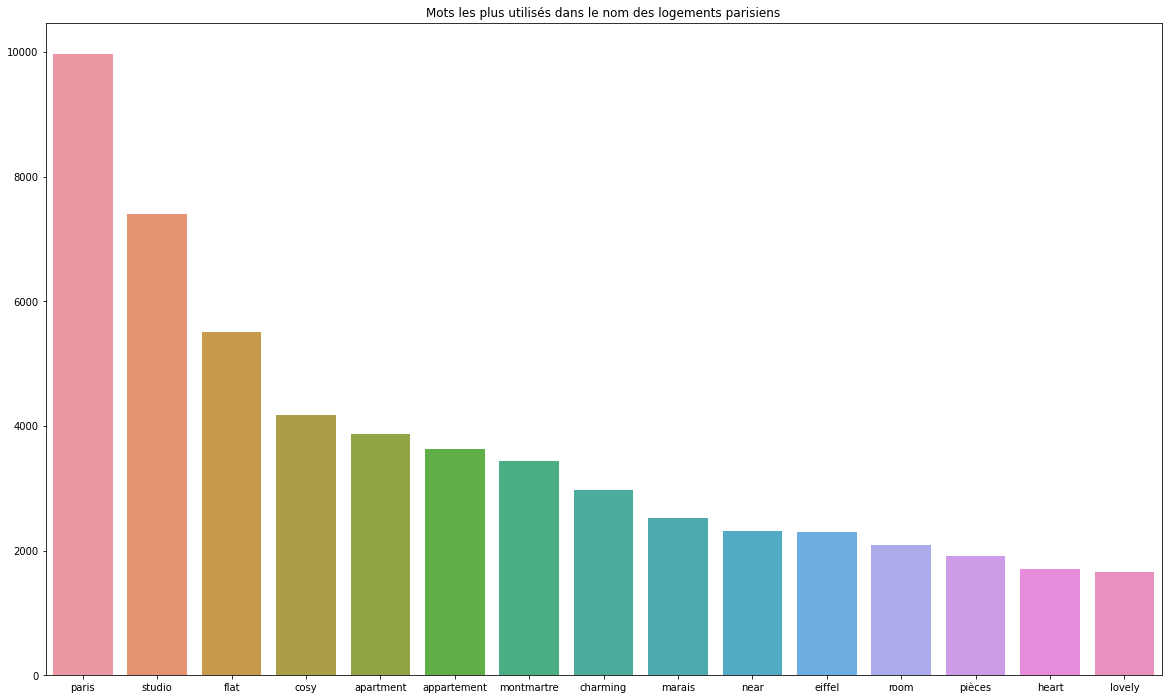

In [33]:
from collections import Counter
import seaborn as sns
dico=Counter(filtered_name)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans le nom des logements parisiens");

# cela nous indique les éléments les plus importants mis en valeur par les propriétaires: le type de logement, leur taille, leur localisation le nombre de pièces
# le nom de la ville est de loin le mot le plus utilisé dans le titre, puisqu'il participe à être facilement trouvable sur le site par les clients
# les propriétaires sont également nombreux à utiliser des adjectifs qualificatifs positifs pour attirer les clients
# Comme nous avons gardé les deux langues on voit qu'en anglais ou en français, les éléments les plus mis en avant sont les mêmes.
# En effet, flat se positionne juste après studio, apartment et appartement sont à côté, ainsi que room et pièces

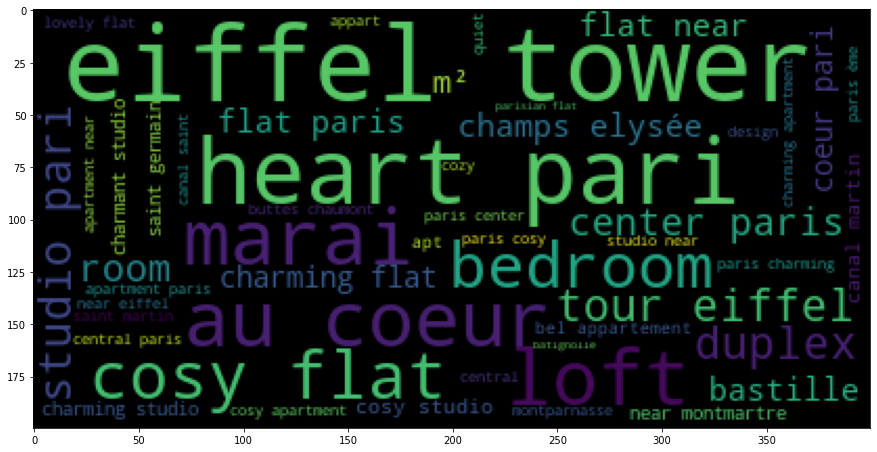

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc=WordCloud(background_color="black",max_words=50,stopwords=stop_words,max_font_size=50,random_state=42)
plt.figure(figsize=(15,8))
wc.generate(name_string)
plt.imshow(wc);

# je ne comprends pas pourquoi certains mots reviennent plusieurs fois.
# il y a des fautes d'orthographe dans les noms propres du fait d'erreurs tapées par les propriétaires? 


In [34]:
#Analysons à présent la variable name de Londres

name_string_london = "\n\n".join(cat_df_london.name)

In [35]:
#nettoyage des données textuelles
name_string_london = re.sub('\s+',' ',name_string_london).strip().lower()
name_string_london[:600]

'spacious 4br home near brixton and clapham lovely 2r flat in the ❤ of brixton lovely bedroom in a cosy house homely two-bed flat in brixton 1 db room in clapham flatshare beautiful spacious apartment in great location amazing house full of character in vibrant brixton small & cosy central 1 bedroom flat home away from home :) leafy clapham - 2 minute from tube relaxing, spacious, bright double room - streatham sofa close to central london - tv and wi-fi inc. victorian hospital with great views quiet nice double room and area in good location 5. charming room in central london beautifully decor'

In [36]:
r=re.compile(r"[0-9]")
name_string_london=r.sub(" ",name_string_london)

r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
name_string_london=r.sub(" ",name_string_london)

r=re.compile(r"[\s]{2,}")
name_string_london=r.sub(" ",name_string_london)

r=re.compile(r"\bdb\b")
name_string_london=r.sub("double",name_string_london)

r=re.compile(r"\bwi\sfi\b")
name_string_london=r.sub("wifi",name_string_london)

r=re.compile(r"\bnr\b")
name_string_london=r.sub("near",name_string_london)

name_string_london[:600]

'spacious br home near brixton and clapham lovely r flat in the ❤ of brixton lovely bedroom in a cosy house homely two bed flat in brixton double room in clapham flatshare beautiful spacious apartment in great location amazing house full of character in vibrant brixton small cosy central bedroom flat home away from home leafy clapham minute from tube relaxing spacious bright double room streatham sofa close to central london tv and wifi inc victorian hospital with great views quiet nice double room and area in good location charming room in central london beautifully decorated garden home in so'

In [37]:
import re
def remove_emojis(name_string_london):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',name_string_london)

In [38]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(name_string_london)
name_london_tokenized=word_tokenize(name_string_london,language="english")


In [39]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","m","one","st","l","s","also"])

def stop_words_filtering(name_london_tokenized) : 
    tokens = []
    for mot in name_london_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

filtered_name_london = [w for w in name_london_tokenized if not w.lower() in stop_words]
filtered_name_london = []
 
for w in name_london_tokenized:
    if w not in stop_words:
        filtered_name_london.append(w)

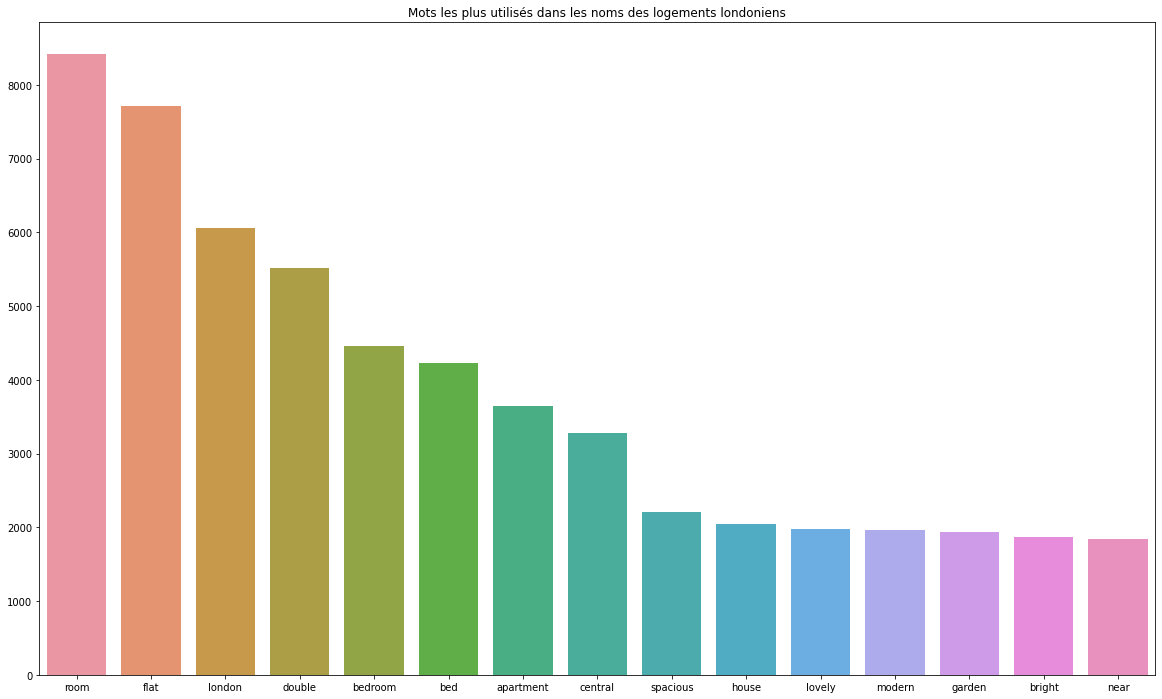

In [40]:
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_name_london)
tokenized=vectorizer.vocabulary_

dico=Counter(filtered_name_london)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans les noms des logements londoniens");

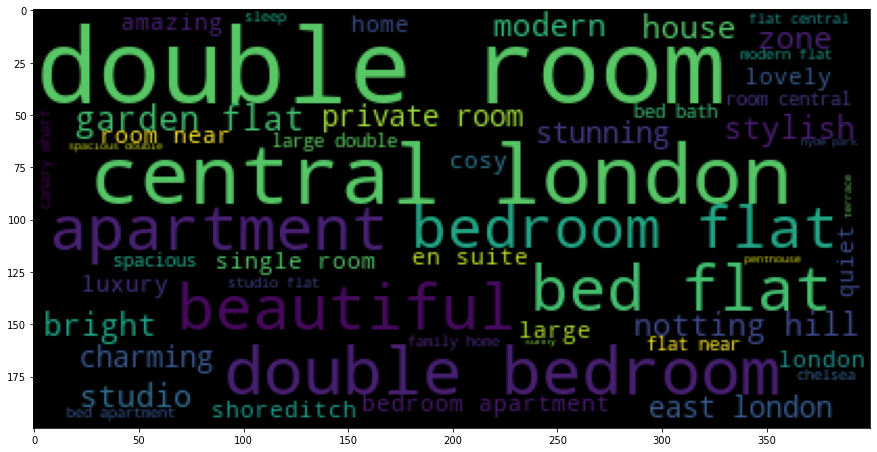

In [ ]:
wc=WordCloud(background_color="black",max_words=50,stopwords=stop_words,max_font_size=50,random_state=42)
plt.figure(figsize=(15,8))
wc.generate(name_string_london)
plt.imshow(wc);

In [ ]:
neighborhood_string = "\n\n".join(cat_df_paris.neighborhood_overview)

TypeError: ignored

In [ ]:
cat_df_paris["neighborhood_overview"].dtype

dtype('O')

In [ ]:
description_string = "\n\n".join(cat_df_paris.description)
description_string = re.sub('\s+',' ',description_string).strip().lower()
r=re.compile(r"[0-9]")
description_string=r.sub(" ",description_string)
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
description_string=r.sub(" ",description_string)
r=re.compile(r"[\s]{2,}")
description_string=r.sub(" ",description_string)
r=re.compile(r"\bdb\b")
description_string=r.sub("double",description_string)
r=re.compile(r"\binc\b")
description_string=r.sub("included",description_string)
r=re.compile(r"\bwi\sfi\b")
description_string=r.sub("wifi",description_string)
r=re.compile(r"\bnr\b")
description_string=r.sub("near",description_string)

In [ ]:
import re
def remove_emojis(description_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',description_string)

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(description_string)
description_tokenized=word_tokenize(description_string,language="english")

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st","et","à","un","est","l","avec","une","pour","en","au"])
# on ajoute des stop words français 

In [ ]:
def stop_words_filtering(description_tokenized) : 
    tokens = []
    for mot in description_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_description = [w for w in description_tokenized if not w.lower() in stop_words]
 
filtered_description = []
 
for w in description_tokenized:
    if w not in stop_words:
        filtered_description.append(w)

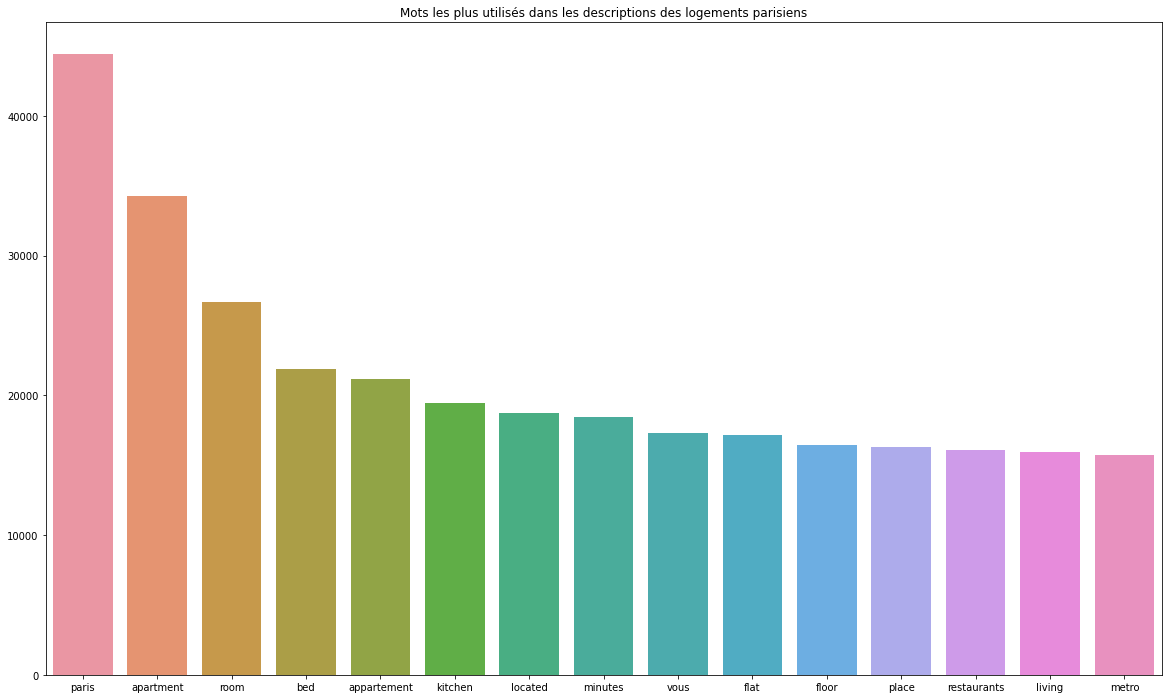

In [ ]:
dico=Counter(filtered_description)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans les descriptions des logements parisiens");


In [ ]:
# on remarque que les descriptions parlent de l'intérieur mais aussi des environs, alors qu'il y a une variable dédiée à cela
# les propriétaires s'adressent souvent de façon directe aux visiteurs dans cette partie (cf "vous")

In [ ]:
description_string_london = "\n\n".join(cat_df_london.description)
description_string_london = re.sub('\s+',' ',description_string_london).strip().lower()
r=re.compile(r"[0-9]")
description_string_london=r.sub(" ",description_string_london)
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
description_string_london=r.sub(" ",description_string_london)
r=re.compile(r"[\s]{2,}")
description_string_london=r.sub(" ",description_string_london)
r=re.compile(r"\bdb\b")
description_string_london=r.sub("double",description_string_london)
r=re.compile(r"\binc\b")
description_string_london=r.sub("included",description_string_london)
r=re.compile(r"\bwi\sfi\b")
description_string_london=r.sub("wifi",description_string_london)
r=re.compile(r"\bnr\b")
description_string_london=r.sub("near",description_string_london)

In [ ]:
import re
def remove_emojis(description_string_london):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',description_string_london)

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(description_string_london)
description_tokenized_london=word_tokenize(description_string_london,language="english")

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","one","st"])

def stop_words_filtering(description_tokenized_london) : 
    tokens = []
    for mot in description_tokenized_london:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_description_london = [w for w in description_tokenized_london if not w.lower() in stop_words]
 
filtered_description_london = []
 
for w in description_tokenized_london:
    if w not in stop_words:
        filtered_description_london.append(w)

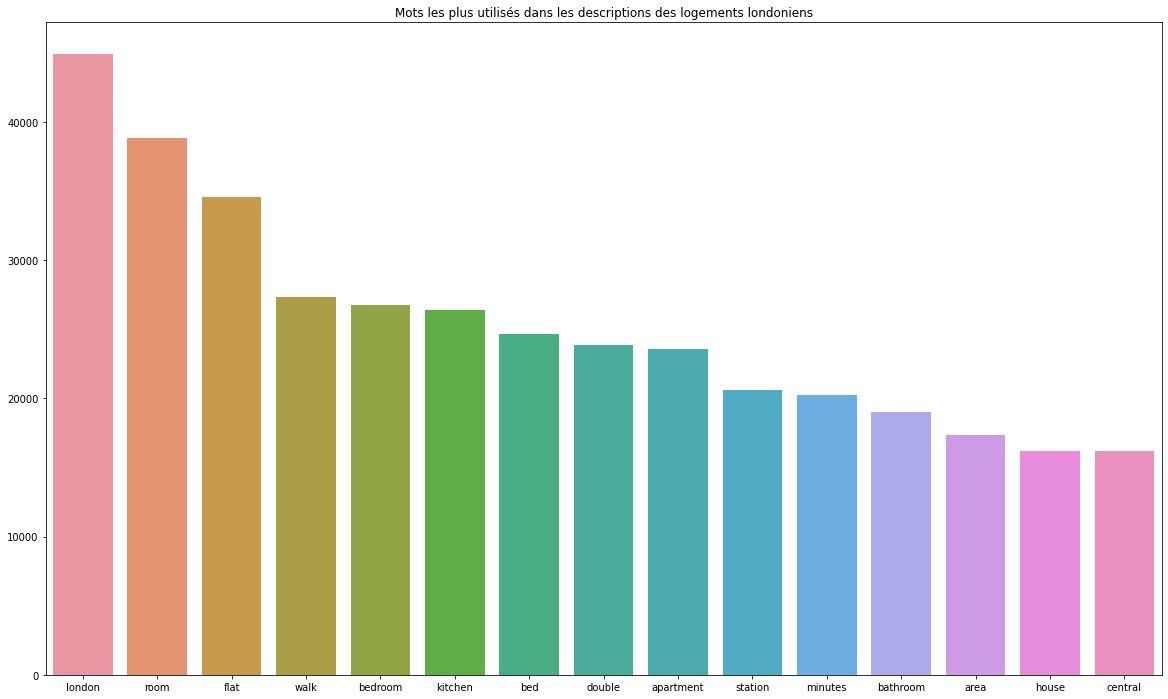

In [ ]:
dico=Counter(filtered_description_london)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans les descriptions des logements londoniens");

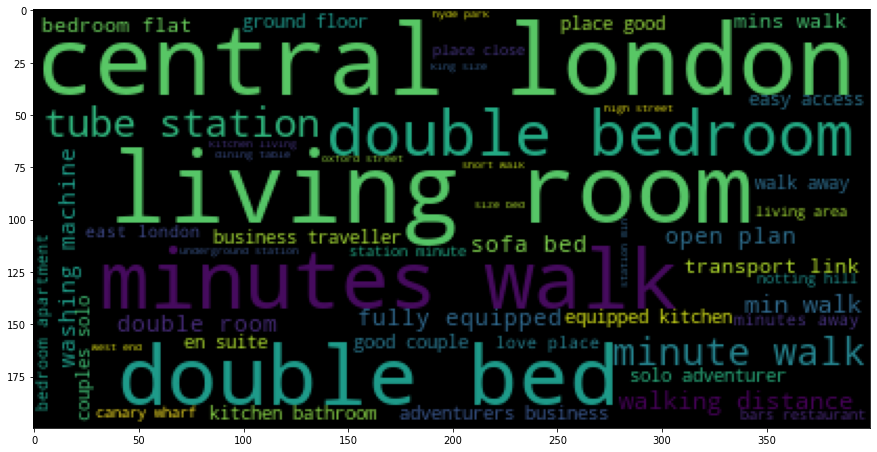

In [ ]:
wc_description_london=WordCloud(background_color="black",max_words=50,stopwords=stop_words,max_font_size=50,random_state=42)
plt.figure(figsize=(15,8))
wc_description_london.generate(description_string_london)
plt.imshow(wc_description_london);

In [ ]:
cat_df_paris.head()

,name,description,neighborhood_overview,transit,interaction,house_rules,host_since,host_about,neighbourhood_cleansed,city,property_type,room_type,bed_type,amenities,first_review,last_review
id,,,,,,,,,,,,,,,,
7735531,Petit cocon au coeur de Paris,"Bienvenue chez moi, j'habite en plein centre d...","Mon quartier ""Le Marais"" est unique à Paris. A...",Mon appartement est à seulement quelques mètre...,Je serais entièrement disponible pour répondre...,De la propreté et du respect ! Prenez svp vos ...,2015-06-11,"Bonjour, je travaille dans l'hôtellerie depuis...",Hôtel-de-Ville,Paris,Apartment,Entire home/apt,Real Bed,"Wireless Internet,Kitchen,Elevator in building...",2015-09-06,2017-04-02
3036231,Enjoy the lovely heart of Paris !,Beautiful and lightful 58 m2 apartment close t...,Le Marais est un quartier incroyable pour se b...,"Proche Ligne 1 (Saint-Paul, Bastille) et 8 (Ch...",NaN,NaN,2013-05-19,"Bonjour tout le monde,\r\n\r\nJe me prénomme P...",Hôtel-de-Ville,Paris,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Heating,...",2014-07-16,2017-02-26
2183529,Studio Saint Paul,Colourful and bright studio for 2 guests in a ...,"Located on a great and quiet neighbourhood, wi...",The closest subway station is Saint Paul on li...,After confirming the booking I send you a welc...,No Pets. No Smoking. No Parties.,2013-12-11,I am an architect with a passion for photograp...,Hôtel-de-Ville,Paris,Apartment,Entire home/apt,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",2014-06-09,2017-02-07
515970,160 M2 Place des Vosges .Marais.,Welcome to this beautiful apartment which is l...,"The apartment is in the center of Paris , in t...","The subway is at one minute , walking distance.",I can help you all the time during your stay,This is a protected historical building which ...,2012-05-27,I am french and I am a painter. I'm in my for...,Hôtel-de-Ville,Paris,Apartment,Entire home/apt,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",2012-08-13,2017-01-03
3144316,Heart Marais-22m2 Lovely Studio,Located in the heart of Marais District (Rue d...,-A Large variety of restaurants (rue des rosie...,The nearest tube stations are Saint Paul line ...,NaN,NaN,2014-05-20,"Hi my name is Lea, I was born in Paris have li...",Hôtel-de-Ville,Paris,Apartment,Entire home/apt,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",2014-06-08,2017-03-16


In [ ]:
interaction_string_london = "\n\n".join(cat_df_london.interaction)


TypeError: ignored

In [ ]:
b